In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import sklearn.metrics as metrics
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

MNIST_train_dataset = torchvision.datasets.MNIST(root = "data", train = True, download = True)
MNIST_test_dataset = torchvision.datasets.MNIST(root = "data", train = False, download = True)

In [23]:
X_train, y_train = torch.load("data/MNIST/processed/training.pt")
X_test, y_test = torch.load("data/MNIST/processed/test.pt")

In [24]:
class MaskedDataset(Dataset):
    def __init__(self, train = True, nonzero_pixels = 6):
        self.nonzero_pixels = nonzero_pixels
        if train == True:
            self.X, self.y = X_train, y_train
        elif train == False:
            self.X, self.y = X_test, y_test
        self.transform = transform
    
    def __getitem__(self, index):
        image = self.X[index]
        non_zero_elements = torch.nonzero(image)
        mask = torch.zeros(image.shape)
        choice_idx = torch.randperm(mask.shape[0])[: self.nonzero_pixels]
        samples = non_zero_elements[choice_idx]
        mask[samples[:, 0], samples[:, 1]] = 1
        image = image - torch.mean(image.float())
        image = image / torch.max(image)
        masked_image = mask * self.X[index]
        label = self.y[index]
        input_feature = torch.cat((mask.unsqueeze(0), masked_image.unsqueeze(0)), dim = 0)
        return input_feature, masked_image, mask, image, label
    
    def __len__(self):
        return self.X.shape[0]

tensor(768.)


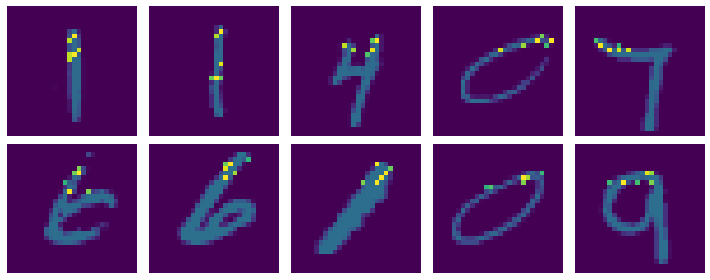

In [25]:
train_dataset = MaskedDataset(train = True)
test_dataset = MaskedDataset(train = False)

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)

nrows = 2
ncols = 5

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (10, 4))

for i, (input_feature, masked_image, mask, image, label) in enumerate(train_loader):
    if i == 0:
        print(mask.sum())
        for j, row in enumerate(axs):
            for k, ax in enumerate(row):
                ax.imshow(mask[j * ncols + k].numpy() + image[j * ncols + k].numpy() * 0.5)
                ax.axis("off")
        plt.tight_layout()
        plt.show()
        break

In [33]:
class Judge(nn.Module):
    def __init__(self):
        super(Judge, self).__init__()
        self.cnn = nn.Sequential(nn.Conv2d(2, 32, 3),
                                         nn.ReLU(),
                                         nn.Conv2d(32, 32, 3),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Dropout(p = 0.25))
        self.classifier = nn.Sequential(nn.Linear(4608, 10),
                                         nn.ReLU(),
                                         nn.Dropout(p = 0.25))
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.shape[0], -1)
        output = self.classifier(x)
        return output

In [35]:
judge = Judge().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(judge.parameters(), lr = 1e-4)
for epoch in range(20):
    running_loss = 0
    outputs = []
    labels = []
    for i, (input_feature, __, __, image, label) in enumerate(train_loader):
        optimizer.zero_grad()
        output = judge(input_feature.cuda())
        loss = criterion(output, label.cuda())
        loss.backward()
        optimizer.step()
        running_loss += loss
        outputs.extend(np.argmax(nn.functional.softmax(output, dim = -1).detach().cpu().numpy(), axis = -1))
        labels.extend(label.detach().cpu().numpy())
    print("At Epoch {}, Loss is {}".format(epoch, running_loss / len(train_loader.dataset)))
    outputs = np.array(outputs)
    labels = np.array(labels)
    print("At Epoch {}, the accuracy is {}".format(epoch, metrics.accuracy_score(outputs, labels)))

At Epoch 0, Loss is 0.01624465174973011
At Epoch 0, the accuracy is 0.3078
At Epoch 1, Loss is 0.014120508916676044
At Epoch 1, the accuracy is 0.39908333333333335
At Epoch 2, Loss is 0.013526389375329018
At Epoch 2, the accuracy is 0.41983333333333334
At Epoch 3, Loss is 0.013288429006934166
At Epoch 3, the accuracy is 0.43191666666666667
At Epoch 4, Loss is 0.013124302960932255
At Epoch 4, the accuracy is 0.4392666666666667
At Epoch 5, Loss is 0.013043643906712532
At Epoch 5, the accuracy is 0.44283333333333336
At Epoch 6, Loss is 0.012973438017070293
At Epoch 6, the accuracy is 0.4458166666666667
At Epoch 7, Loss is 0.012925321236252785
At Epoch 7, the accuracy is 0.4472833333333333
At Epoch 8, Loss is 0.01291445642709732
At Epoch 8, the accuracy is 0.4465
At Epoch 9, Loss is 0.012878306210041046
At Epoch 9, the accuracy is 0.4490166666666667
At Epoch 10, Loss is 0.01281055249273777
At Epoch 10, the accuracy is 0.4508333333333333
At Epoch 11, Loss is 0.012785317376255989
At Epoch 11

KeyboardInterrupt: 

In [ ]:
class PixelDebatePlayer():
    def __init__(self, precommit, is_honest):
        self.precommit = precommit
        self.is_honest = is_honest
        self.tree = PixelDebateMCTS()

class PixelDebateGame():
    def __init__(self, image, judge, player_1, player_2, game_length, rollous_per_move = 10000, seed = 0):
        self.image = image
        self.judge = judge
        self.player_1 = player_1
        self.player_2 = player_2
        self.game_length = game_length
        self.rollouts_per_move = rollouts_per_move
        random.seed(seed)
    
    def other_player(self, player):
        return self.player_1 if player == self.player_2 else self.player_2
    
    def masked_image(self, moves_played):
        indices = np.array(moves_played)
        xs, ys = indices[:, 0], indices[:, 1]
        img = np.zeros(self.images.shape)
        img[xs, ys] = self.image[xs, ys]
        return img
    
    def judge_verdict(self, moves_played):
        return self.judge(self.masked_image(move_played))
    
    def winner(self, moves_played):
        verdict = self.judge_verdict(moves_played)
        
        for player in [self.player_1, self.player_2]:
            if verict == player.commit or (player.precommit is None and veridict != self.other_player(player).precommit):
                return player
        return None
    def play(self):
        moves_played = []
        current_player = self.player_1
        
        for _ in range(6):
            state = PixelDebateMCTSNode(
                                    game = self,
            searcher = current_player,
            moves_played = moves_played)
            
            for _ in range(self.rollouts_per_move):
                current_player.tree.choose(state)
                
            next_state = current_player.tree.choose(state)
            moves_played = next_state.moves_played
            current_player = state_adversary
        return moves_played
    
def pixelDebateMCTSNode(MCTSNode):
    def __init__(self, game, searcher, current_player, moves_played):
        """
        A state of play in the debate game
        params:
        - game: Description of the current game
        - searcher: The player who is performing the search
        - current_player: The player whose turn it is to make a move
        - moves_played: List of corrdinates that have been played so far
        """
        self.game = game
        self.searcher = searcher
        self.adversary = game.other_player(searcher)
        self.current_player = current_player or searcher
        self.moves_played = moves_played
        
    def find_children(self):
        """
        All possible successor of this board state.
        """
        next_player = self.game.other_player(self.current_player)
        
        return {PixelDebateMCTSNode(self.game, self.searcher, next_player, self.moves_played + [tuple(coord),] for coord in np.argwhere(self.game.image) if tuple(coord) not in self.moves_played)}
    
    def find_random_child(self):
        """
        Random successor of this board state (for more efficient simulation)
        """
        if self.is_terminal():
            return None
        return random.choice(list(self.find_children()))
    
    def is_terminal(self):
        return len(self.moves_played) >= self.game.game_length
    
    def reward(self):
        """
        Assume self is terminal node. 1 = win, 0 = loss, .5 = tie, etc.
        """
        winner = self.game.winner(self.moves_played)
        if winner = self.searcher:
            return 1
        if winner = self.adversary:
            return 0
        return 0.5
    
    def __hash__(self):
        """
        Nodes must be hashable
        """
        coords = sorted(self.moves_played)
        return hash(str(coords))
    
    def __eq__(node1, node2):
        """
        Nodes must be comparable
        """
        return set(node1.moves_played) == set(node_2.moves_played) and node1.game == node2.game

class PixelDebateMCTS(MCTS):
    def __select_decendent(self, node):
        def U(n):
            p = 1.0 / np.sum(n.game.image > 0)
            child_visit = sum([self.N[c] for c in self.children.get(n, [])])
        
        def puct(n):
            return self.Q[n] + U(n)
        
        return max(self.children[node], key = puct)